# Building a Movie Recommender System
- Michael Carnival
- Hector R. Gavilanes

Department of Mathematics & Statistics
University of West Florida
Summer 2024

https://youtu.be/dVNlEcmw_EY

## Introduction
The topic we were excited to learn and tackle was how to use or build a recommender system to help make decisions based on user preference or scenarios of a specific situation. A recommender system is everywhere these days. Social media platforms like Facebook, YouTube, and TikTok use recommender to help individuals find friends, create for your page (FYP),  recommend videos to watch, etc. E-commerce websites like Amazon or eBay use a recommender system to recommend 'frequently bought together'.  Hospital doctors can give personalized treatment plans, medication options, and lifestyle changes based on individual health profiles. From the examples we illustrated above, recommender systems are beneficial for enhancing user experiences, increasing sales, and simplifying decision-making by suggesting relevant options. To demonstrate and learn, we will show how movies are recommended to users as a starting journey to the world of recommender systems. In our project, we will focus on using collaborative filtering to generate movies we watch based on other user preferences.

In [ ]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load data

The dataset we will be using to create our movie recommender will be from GroupLens research group at the University of Minnesota
[grouplen](https://grouplens.org/datasets/movielens/). We will be dealing with 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users [small dataset](https://files.grouplens.org/datasets/movielens/ml-latest-small.zip). For anyone who desire [larger dataset](https://files.grouplens.org/datasets/movielens/ml-latest.zip)

In [ ]:
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Exploratory Data Analysis
We explore the dataset to understand the distribution of ratings and identify the most rated movies.

In [ ]:
n_ratings =len(ratings)
n_movies =len(movies)
n_users =len(ratings.userId.unique())

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9742
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.35


The average number of ratings per user suggest that each person has rated ~165 different movies. The average number of ratings per movie suggest that some movies gets rated more often than some other movies

## Distribution of movie ratings

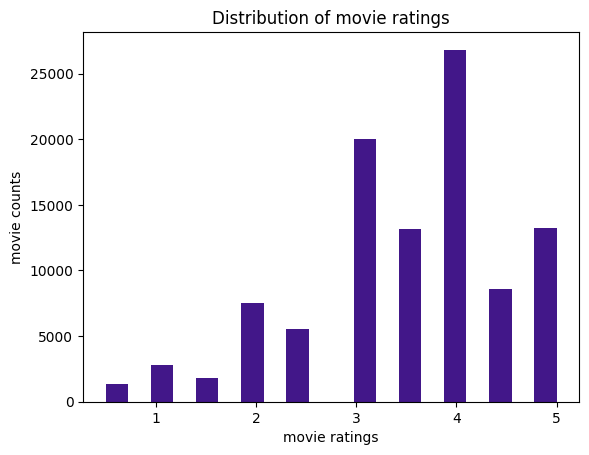

In [ ]:
plt.hist(x = ratings.rating, bins=20, color='#421789')
plt.xlabel('movie ratings')
plt.ylabel('movie counts')
plt.title('Distribution of movie ratings')
plt.show()

The histgram 'distribution of movie' ratings shows that most movies receive ratings of 3 or 4, with 4 being the most common. Ratings of 1 and 2 are less frequent, and ratings of 5 are also relatively low. This pattern suggests that moviegoers tend to rate movies moderately rather than extremely.

In [ ]:
print('Overall average movie rating ', round(ratings.rating.mean(),2))

Overall average movie rating  3.5


The overall average movie rating of 3.5 further supports that people tend to rate on the higher end.

In [ ]:
movies_ratings = pd.merge(left = ratings, right= movies, on = 'movieId', how = 'left')
movies_ratings.shape

(100836, 6)

The code above uses a left join on the ratings and the movie dataset on movieID. This will return all the records from ratings table and only the matching records from the movies table.

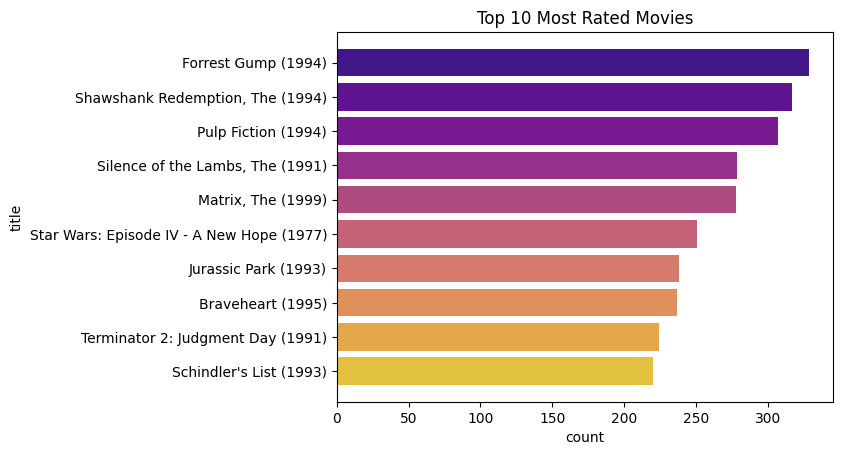

In [ ]:
top_10_most_rated = pd.DataFrame(movies_ratings['title'].value_counts()[:10]).reset_index()
sns.barplot(data = top_10_most_rated, y = top_10_most_rated['title'].astype(str), x = top_10_most_rated['count'],
            palette='plasma', hue='title')
plt.plot()
plt.xlabel("count")
plt.ylabel("title")
plt.title("Top 10 Most Rated Movies")
plt.show()


The code above displays the top 10 most rated movies in the dataset

In [ ]:
mean_ratings = movies_ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings.rating.idxmin()
highest_rated = mean_ratings.rating.idxmax()

print('lowest rated movie: ', movies[movies['movieId'] == lowest_rated].title)
print('highest rated movie: ', movies[movies['movieId'] == highest_rated].title)


lowest rated movie:  2689    Gypsy (1962)
Name: title, dtype: object
highest rated movie:  48    Lamerica (1994)
Name: title, dtype: object


Gypsy has the lowest rated movie

Lamerica has the highest rated movie

In [ ]:
# how many rating does lamerica have
print('Number of rating(s) for Gypsy :', len(ratings[ratings['movieId'] == lowest_rated]))
# how many rating does lamerica have
print('Number of rating(s) for Lamerica:', len(ratings[ratings['movieId'] == highest_rated]))

Number of rating(s) for Gypsy : 1
Number of rating(s) for Lamerica: 2


As we can see from above, 'Gypsy' and 'Lamerica' are the lowest and highest-rated movies respectively. However, both movies have **low quantity** of ratings.

## Popularity-Based Filtering
The *quantity* of ratings is as important as the rating itself because the more ratings a movie has, the more confidence we have in the rating. To deal with the low quantity ratings issue, the *Bayesian Average* can be of help in **lowering artificially high ratings by weighing it down to the lower catalog average.** Also, **for items with a lot of ratings**, the **Bayesian Average** doesn't change its rating average significantly.


#### Bayesian Average
Bayesian Average is defined as:

$r_{i} = \frac{C \times m + \Sigma{\text{reviews}}}{C+N}$

where $C$ represents our confidence, $m$ represents our prior, and $N$ is the total number of reviews for movie $i$. In our case, prior $m$ will be the average rating across all movies. The C is chosen based "the typical data set size" required for a robust estimate of the sample mean. Let's make $C$ be the average number of ratings for a given movie.

In [ ]:
# count of rating and the average rating per movie
movie_stats = ratings.groupby('movieId')['rating'].agg(['count','mean']).reset_index()

In [ ]:
c = movie_stats['count'].mean()
m = movie_stats['mean'].mean()
print(f"Average number of ratings received for a given movie, {c: .2f}")
print(f"Average rating score for a given movie, {m: .2f}")



def bayesain_avg(ratings):
    return (c * m + ratings.sum())/(c + ratings.count())

Average number of ratings received for a given movie,  10.37
Average rating score for a given movie,  3.26


Testing out the Bayesian Average function on high quantity rating movie (Forrest Gump) and low quantity movies (lamerica)

In [ ]:
forrest_gump = movies_ratings[movies_ratings['title'] == 'Forrest Gump (1994)'].rating
print('Forrest Gump Original Arithmetic Average Rating With 329 User Ratings: ', round(forrest_gump.mean(),2))
# number of rating and what the rating is
print('Forrest Gump Bayesian Average Rating: ', round(bayesain_avg(forrest_gump),1))

print('lamerica Original Rating With 2 User Rating: ', ratings[ratings['movieId'] == highest_rated].values[:,2].mean())
# number of rating and what the rating is
lamerica = pd.Series([5,5])
print('Lamerica Bayesian Average Rating: ', round(bayesain_avg(lamerica),1))

Forrest Gump Original Arithmetic Average Rating With 329 User Ratings:  4.16
Forrest Gump Bayesian Average Rating:  4.1
lamerica Original Rating With 2 User Rating:  5.0
Lamerica Bayesian Average Rating:  3.5


Through the Bayesian Average function the rating for Lamerica's when from a of 5.0 to 3.5 and for Forrest Gump, the rating remain similar with the original rating of ~ 4.1.

Applying Bayesian Function to all movies ratings

In [ ]:
bayesain_avg_ratings = ratings.groupby('movieId')['rating'].apply(bayesain_avg).reset_index()
bayesain_avg_ratings.columns = ['movieId', 'bayesain_avg']
movie_stats = pd.merge(left = movie_stats, right= bayesain_avg_ratings, on = 'movieId', how = 'left' )

merging movie_stats to movies to get the movie title using a left join.

In [ ]:
movie_stats = movie_stats.merge(movies[['movieId','title']]) # only select two columns from the dataframe
movie_stats.head()

,movieId,count,mean,bayesain_avg,title
0,1,215,3.920930,3.890632,Toy Story (1995)
1,2,110,3.431818,3.417227,Jumanji (1995)
2,3,52,3.259615,3.260086,Grumpier Old Men (1995)
3,4,7,2.357143,2.897612,Waiting to Exhale (1995)
4,5,49,3.071429,3.104793,Father of the Bride Part II (1995)


In [ ]:
# Sort movies by Bayesian average
movie_stats.sort_values(by = 'bayesain_avg', ascending=True).head()

,movieId,count,mean,bayesain_avg,title
1172,1556,19,1.605263,2.190377,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224426,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267268,Godzilla (1998)
1144,1499,27,1.925926,2.296800,Anaconda (1997)
1988,2643,16,1.687500,2.306841,Superman IV: The Quest for Peace (1987)


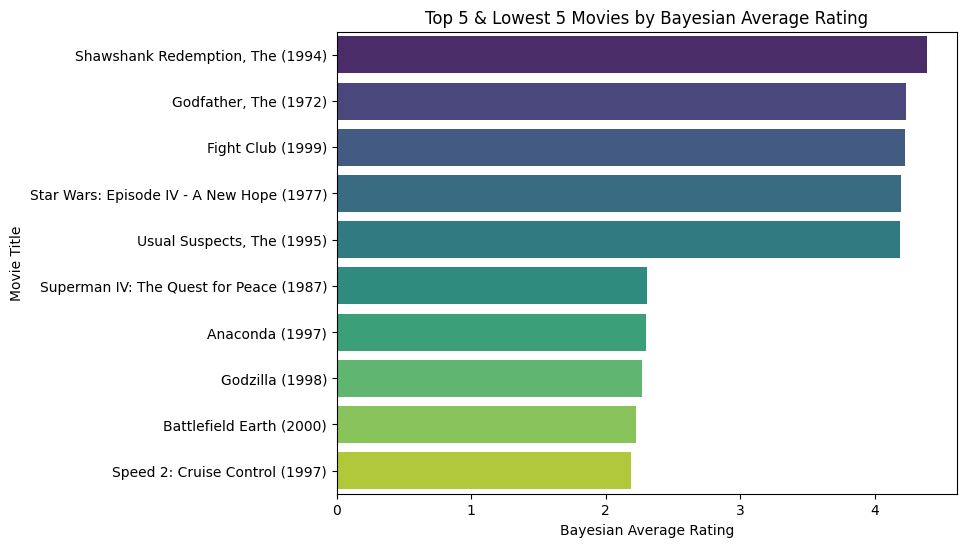

In [ ]:
# Sort movies by Bayesian average
sorted_movies = movie_stats.sort_values(by = 'bayesain_avg', ascending=False)

# Select top 5 and lowest 5 movies
top_5_movies = sorted_movies.head(5)
lowest_5_movies = sorted_movies.tail(5)

# Concatenate top and lowest movies for plotting
top_and_lowest_movies = pd.concat([top_5_movies, lowest_5_movies])

# Plotting
plt.figure(figsize=(8, 6))
sns.barplot(data=top_and_lowest_movies, y='title', x='bayesain_avg', palette='viridis', hue='title')
plt.xlabel('Bayesian Average Rating')
plt.ylabel('Movie Title')
plt.title('Top 5 & Lowest 5 Movies by Bayesian Average Rating')
plt.show()

Now, that we have the ratings sorted out to be more representative. We are going to investigate the genres of the movies.

In [ ]:
# split genres and convert the genre into a list
movies['genres'] = movies['genres'].apply(lambda x: x.split(sep = '|'))

In [ ]:
from collections import Counter
genre_frequency = Counter(g for gs in movies['genres'] for g in gs)
print(f"There are {len(genre_frequency)} of genres")
print(f"The top 5 most frequent genre are {genre_frequency.most_common(5)}")

There are 20 of genres
The top 5 most frequent genre are [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


In [ ]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns =  ['genre', 'count']

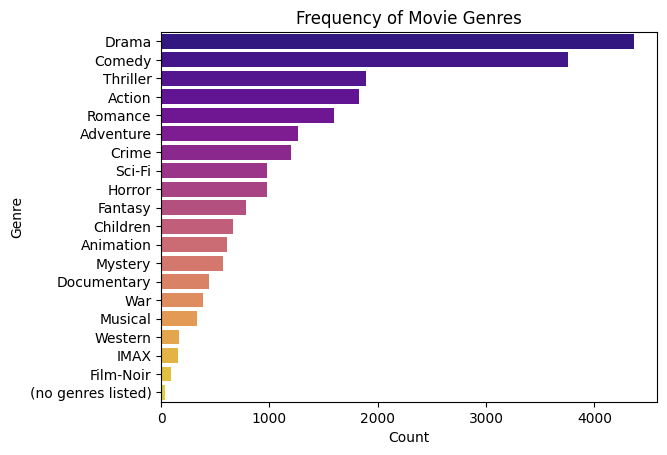

In [ ]:
sns.barplot(y = 'genre', x = 'count', hue = 'genre', data = genre_frequency_df.sort_values(by = 'count', ascending=False), palette= 'plasma')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.title('Frequency of Movie Genres')
plt.show()

The bar graph shows that Drama is the most common film genre, followed by Comedy and Thriller. Western and Film-Noir are the least common genres.

In [ ]:
movies_ratings[['userId','movieId','rating']].head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


The plot above shows that drama and comedy are the most frequent genre in our dataset.

# Data Pre-processing

In our current data matrix, the user and movie id are column vectors.

| userId | movieId | rating |
|-------:|--------:|-------:|
|      1 |       1 |    4.0 |
|      1 |       3 |    4.0 |
|      1 |       6 |    4.0 |
|      1 |      47 |    5.0 |
|      1 |      50 |    5.0 |
| ...    | ...     | ...    |

In order to conduct the user based collaborative filtering recommendation system, first we need to discuss what it is.

## Collaborative Filtering
### User-Based Collaborative Filtering
A user-based collaborative filtering works by finding users who have a similar taste of products or movie as the current user. For collaborative filtering to work we will need to do couple of things. The first step is to transform our data into a user-item matrix where rows represent users and columns represent movies. This configuration is shown


| userId | movie_id1 | movie_id2 | ... | movie_idn |
|-------:|----------:|----------:|----:|----------:|
|      1 |   rating1 |   rating2 | ... |       ... |
|      2 |   rating1 |   rating2 | ... |       ... |
|    ... |       ... |       ... | ... |       ... |
|      n |       ... |       ... | ... |       ... |

To do this transformation, we will need a function that outputs a sparse matrix with four mapper dictionaries starting with the **movie mapper**, which will maps movie id to movie index. A **user mapper** for mapping user id to a user index, a **movie inverse mapper** to map movie index to movie id and a **user inverse mapper** to map user index to user id. The function below will do just that.


In [ ]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.

    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)

    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['userId'].nunique()
    N = df['movieId'].nunique()


    movie_mapper = dict(zip(np.unique(df['movieId']), list(range(N))))
    user_mapper = dict(zip(np.unique(df['userId']), list(range(M))))


    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df['movieId'])))
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df['userId'])))

    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index, item_index)), shape = (M,N))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)


### Evaluating sparsity

Here, we calculate sparsity by dividing the number of stored elements by total number of elements. The number of stored (non-empty) elements in our matrix ([nnz](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.nnz.html)) is equivalent to the number of ratings in our dataset.

In [ ]:
n_total = X.shape[0] * X.shape[1]
n_ratings = X.nnz
sparsity = 1-n_ratings/n_total

print(f"Matrix sparsity: {sparsity*100:.1f}%")

Matrix sparsity: 98.3%


In user-based collaborative filtering, a sparsity value of less than or equal to 99.5% is often preferred because it ensures that there are enough interactions between users and items to make meaningful recommendations. When the sparsity value is too high, it means that the user-item interaction matrix is extremely sparse, with very few interactions recorded. Overall, a sparsity value of less than or equal to 99.5% balance out between having enough data to make accurate recommendations and maintaining computational efficiency [sparsity](https://stats.stackexchange.com/questions/367380/why-the-maximum-sparsity-is-99-5-in-collaborative-filtering).


In [ ]:
n_ratings_per_user = X.getnnz(axis =1)
print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

n_ratings_per_movie = X.getnnz(axis =0)
print(f"\nMost rated movie has {n_ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings.")

Most active user rated 2698 movies.
Least active user rated 20 movies.

Most rated movie has 329 ratings.
Least rated movie has 1 ratings.


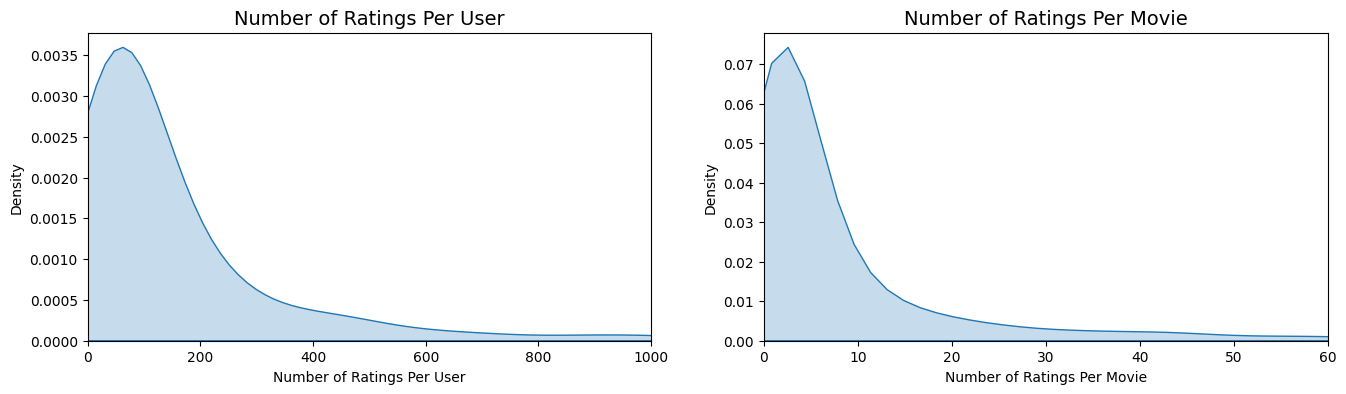

In [ ]:
plt.figure(figsize=(16, 4))

# Plot for Number of Ratings Per User
plt.subplot(1, 2, 1)
sns.kdeplot(n_ratings_per_user, fill=True)
plt.xlim(0, 1000)  # Adjust x-axis limits
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("Number of Ratings Per User")
plt.ylabel("Density")

# Plot for Number of Ratings Per Movie
plt.subplot(1, 2, 2)
sns.kdeplot(n_ratings_per_movie, fill=True)
plt.xlim(0, 60)  # Adjust x-axis limits
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("Number of Ratings Per Movie")
plt.ylabel("Density")

plt.show()

The two graphs show that most users rate only a few items, and most movies receive only a few ratings. This highlights the typical sparsity in user-item interaction datasets, where a small number of users and movies account for the majority of ratings.

## Normalization

Normalization is important in recommendation systems as it helps to remove systematic biases from the ratings. Users may have different rating scales, and items may receive consistently high or low ratings due to factors unrelated to their quality. By normalizing the ratings, we can make the data more suitable for collaborative filtering. This process ensures that the recommendations are based on genuine user preferences rather than biases, leading to more accurate and fair recommendations.

In [ ]:
from scipy.sparse import csr_matrix

# Convert to dense matrix
dense_matrix = X.toarray()

# Calculate global mean, user bias, and item bias
global_mean = np.mean(dense_matrix[dense_matrix != 0])
user_bias = np.mean(dense_matrix, axis=1) - global_mean
item_bias = np.mean(dense_matrix, axis=0) - global_mean

# Normalize the ratings
non_zero_mask = dense_matrix != 0
normalized_matrix = dense_matrix - global_mean - user_bias[:, np.newaxis] - item_bias
normalized_matrix[~non_zero_mask] = 0


## Model Implementation

The code below defines a function `find_similar_movies` that identifies the top-k similar movies to a given movie using the k-Nearest Neighbors (kNN) algorithm. The function first transposes the user-item matrix `X` and retrieves the vector corresponding to the specified `movie_id`. It then initializes and fits a kNN model using the "brute" algorithm and the specified distance metric (e.g., **cosine similarity**). The function finds the k+1 nearest neighbors to the movie vector, excluding the movie itself, and maps the indices of these neighbors back to their original movie IDs using the `movie_inv_mapper` dictionary.

## Finding Similar Movies
We use the k-Nearest Neighbors (kNN) algorithm with cosine similarity to find movies similar to a given movie.

In [ ]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k=10, metric='cosine'):
    # Transpose the user-item matrix
    X = X.T

    # Retrieve the vector for the specified movie and reshape it to 2D
    movie_vec = X[movie_mapper[movie_id]].reshape(1, -1)

    # Initialize the k-Nearest Neighbors model
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)

    # Fit the kNN model to the transposed matrix
    kNN.fit(X)

    # Find the k+1 nearest neighbors to the movie vector (including the movie itself)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False).flatten()[1:k+1]

    # Map the indices of the neighbors back to their original movie IDs
    return [movie_inv_mapper[n] for n in neighbour]

similar_movies = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, k=10)
print(similar_movies)

[3114, 480, 780, 260, 356, 364, 1210, 648, 1265, 1270]


In [ ]:
movie_titles = dict(zip(movies['movieId'], movies['title']))
movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='euclidean', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Toy Story 2 (1999)
Mission: Impossible (1996)
Independence Day (a.k.a. ID4) (1996)
Bug's Life, A (1998)
Nutty Professor, The (1996)
Willy Wonka & the Chocolate Factory (1971)
Babe (1995)
Groundhog Day (1993)
Mask, The (1994)
Honey, I Shrunk the Kids (1989)


The **cold-start problem** occurs in collaborative filtering when new users or items with no interactions are excluded from the recommendation system. This happens because collaborative filtering relies solely on user-item interactions within the utility matrix. Content-based filtering can address this issue by generating recommendations based on user and item features.

## Content-based Filtering
Content-based filtering is a recommendation technique that suggests items to users based on the features of items they have previously interacted with or liked. This method involves creating profiles for each item using a set of attributes, such as genre, director, and keywords for movies. A user profile is then built based on the features of items the user has shown interest in. The system calculates the similarity between the user profile and item profiles, often using techniques like cosine similarity. Items that are most similar to the user's profile are recommended [IBM].

This code converts the genres column into binary features, where each genre has its own column populated with 0 or 1, making it suitable for content-based filtering to handle the cold-start problem.

In [ ]:
# Count the number of unique movies in the dataset
n_movies = movies['movieId'].nunique()
print(f"There are {n_movies} unique movies in our movies dataset.")

# Extract unique genres from the 'genres' column
genres = set(g for gs in movies['genres'] for g in gs)

# Create binary columns for each genre
for g in genres:
    movies[g] = movies.genres.transform(lambda x: int(g in x))

# Drop unnecessary columns to create the final movie_genres dataframe
movie_genres = movies.drop(columns=['movieId', 'title', 'genres'])


There are 9742 unique movies in our movies dataset.


In [ ]:
movies.head(5)

,movieId,title,genres,Adventure,Thriller,(no genres listed),Horror,Animation,Drama,Comedy,...,Crime,Sci-Fi,Western,Musical,Mystery,Romance,IMAX,War,Documentary,Children
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",0,0,0,0,0,1,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),[Comedy],0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
movie_genres.head()

,Adventure,Thriller,(no genres listed),Horror,Animation,Drama,Comedy,Film-Noir,Fantasy,Action,Crime,Sci-Fi,Western,Musical,Mystery,Romance,IMAX,War,Documentary,Children
0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


## Cosine Similarity Matrix between Movie Genre

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate the cosine similarity between the genre features of movies
cosine_sim = cosine_similarity(movie_genres, movie_genres)

# Print the dimensions of the cosine similarity matrix
print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")


Dimensions of our genres cosine similarity matrix: (9742, 9742)


This cosine_sim matrix can be used to find movies that are similar to each other based on their genres

The `movie_finder()` function leverages the fuzzywuzzy module to find the most similar movie title to a user-inputted string using fuzzy string matching. This approach is useful for handling variations in user input, such as typos or partial titles, ensuring that the system can accurately identify and recommend the intended movie even if the input is not an exact match.

In [ ]:
!pip install fuzzywuzzy
from fuzzywuzzy import process

def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title, all_titles)
    return closest_match[0]
title = movie_finder('orrest Gump (1994)')
title

'Forrest Gump (1994)'

To obtain relevant recommendations for `Toy Story` we first need to find its index in the cosine similarity matrix. To determine the appropriate row, we can create a movie index mapper that maps each movie title to its corresponding index in the matrix.

In [ ]:
# Create a movie index mapper
movie_idx = dict(zip(movies['title'], list(movies.index)))

# Find the index for the specified movie title
idx = movie_idx[title]
print(f"Movie index for '{title}': {idx}")

Movie index for 'Forrest Gump (1994)': 314


In [ ]:
movie_idx['Forrest Gump (1994)']

Using the `movie_idx` dictionary, we know that Forrest Gump is represented by index 314 in our matrix. To find the top 10 most similar movies to Forrest Gump, the code below calculates and sorts the similarity scores for all movies relative to Forrest Gump and then selects the top `n_recommendations` similar movies based on these scores.

In [ ]:
# Set the number of recommendations to retrieve
n_recommendations = 10

# Get the similarity scores for the given movie index
sim_scores = list(enumerate(cosine_sim[idx]))

# Sort the similarity scores in descending order
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

# Select the top n_recommendations similar movies, excluding the first one (the movie itself)
sim_scores = sim_scores[1:(n_recommendations+1)]

sim_scores


In [ ]:
# Extract the first element (movie) from each tuple in sim_scores
similar_movies = [i[0] for i in sim_scores]
similar_movies

similar_movies is an list of indices representing the top 10 recommendations for Forrest Gump. To obtain the corresponding movie titles, we can either create an inverse mapping of movie indices or use the iloc method on the title column of the movies DataFrame.”

In [ ]:
print(f"Because you watched {title}:")
movies['title'].iloc[similar_movies]

The function get_content_based_recommendations takes a movie title and the number of recommendations (defaulting to 10) as inputs. It finds the movie’s index, calculates cosine similarity scores with other movies, sorts these scores, and selects the top recommendations (excluding the movie itself). Finally, it prints a message indicating the recommendations are based on the given movie and displays the titles of the recommended movies using the iloc method on the movies DataFrame.

In [ ]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_movies = [i[0] for i in sim_scores]
    print(f"Because you watched {title}:")
    print(movies['title'].iloc[similar_movies])

In [ ]:
get_content_based_recommendations('Forrest Gump', 10)

Because you watched Forrest Gump (1994):
1730           Life Is Beautiful (La Vita è bella) (1997)
2262                  Train of Life (Train de vie) (1998)
6296    Tiger and the Snow, The (La tigre e la neve) (...
6624    I Served the King of England (Obsluhoval jsem ...
3                                Waiting to Exhale (1995)
10                         American President, The (1995)
47                                Mighty Aphrodite (1995)
52                      Postman, The (Postino, Il) (1994)
83                                 Beautiful Girls (1996)
165                        Something to Talk About (1995)
Name: title, dtype: object


# Conclusion

The learning offers an exciting journey into the world of recommender systems, highlighting their crucial role in enhancing user experiences across platforms like social media, e-commerce, and healthcare. Using the MovieLens dataset, it guides us through the captivating process of data loading, exploration, and visualization, uncovering patterns in movie ratings and popular films. It delves into user-based collaborative filtering, demonstrating how to create a user-item matrix, assess sparsity, and normalize ratings. Additionally, it briefly address the cold-start problem with content-based recommendations, using genre features to calculate cosine similarity and discover similar movies. This exprience ignites our curiosity and fuels our desire to delve deeper into the mechanics of recommendation systems, making it an invaluable resource for application in other fields.

# Citation

[grouplen](https://grouplens.org/datasets/movielens/)

[small dataset](https://files.grouplens.org/datasets/movielens/ml-latest-small.zip)

[larger dataset](https://files.grouplens.org/datasets/movielens/ml-latest.zip)

[bayesian average](https://www.algolia.com/doc/guides/managing-results/must-do/custom-ranking/how-to/bayesian-average/)

[sparsity](https://stats.stackexchange.com/questions/367380/why-the-maximum-sparsity-is-99-5-in-collaborative-filtering)

[salemmarafi](https://www.salemmarafi.com/code/collaborative-filtering-with-python/)

[recommender pipeline](https://www.youtube.com/watch?v=v_mONWiFv0k)

[content based filtering](https://www.ibm.com/topics/content-based-filtering)
